# Import Model

In [1]:
#imports
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt

In [2]:

alexnet = models.alexnet(pretrained=True)


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 224, 224])


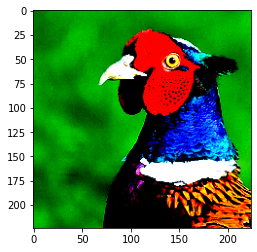

In [4]:
preprocessing = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

images = torchvision.datasets.ImageFolder(root= "/content/drive/MyDrive/Colab Notebooks/Project/", transform=preprocessing)

image = images[7][0]
plt.imshow(image.permute(1,2,0))
image_final = image.unsqueeze(0)

image_final.requires_grad_()
print(image_final.shape)


# Calculate Saliency map

#Working

tensor(86)
tensor(21.1967, grad_fn=<SelectBackward>)


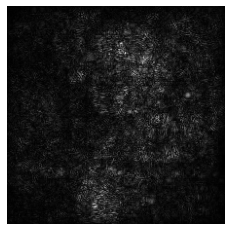

In [5]:
def calcImageGrad(image, model):
  model.eval()
  image.requires_grad_()
  output = model(image)
  class_ind = output.argmax()
  #print(class_ind)
  grad = output[0, class_ind]
  print(grad)
  grad.backward()
  return torch.max(image.grad.data.abs(), dim=1)[0]

def print_progress(i,n):
  if i == 0:
    print("_"*n)
  if i>=n:
    return
  else:
    print("-", end = "")

def smoothGrad(stdev, n, input, model):
  grad_stdev = float((stdev/100)*(torch.max(input[0])-torch.min(input[0])))
  print("standard dev: ", grad_stdev)
  total =  torch.from_numpy(np.zeros(input.shape))
  image_tensor = input
  for i in range(n):
    print_progress(i,n)
    size = input.shape
    input_image = (image_tensor.detach() + np.random.normal(0,grad_stdev, size = size)).float()
    input_image.requires_grad_()
    image_grad = calcImageGrad(input_image, model)
    total = total+image_grad
  return (total/n)


saliency = calcImageGrad(image_final, alexnet)
# code to plot the saliency map as a heatmap
plt.imshow(saliency[0], cmap=plt.cm.gray)
plt.axis('off')
plt.show()


#without progress bar

tensor(850)
tensor(13.4930, grad_fn=<SelectBackward>)


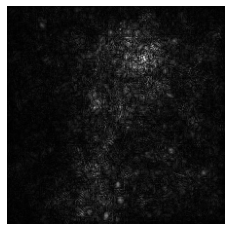

In [6]:
def calcImageGrad(image, model):
  model.eval()
  image.requires_grad_()
  output = model(image)
  class_ind = output.argmax()
  #print(class_ind)
  grad = output[0, class_ind]
  #print(grad)
  grad.backward()
  return torch.max(image.grad.data.abs(), dim=1)[0]


def smoothGrad(stdev, n, input, model):
  grad_stdev = float((stdev/100)*(torch.max(input[0])-torch.min(input[0])))
  #print("standard dev: ", grad_stdev)
  total =  torch.from_numpy(np.zeros(input.shape))
  image_tensor = input

  for i in range(n):
    #print_progress(i,n)
    size = input.shape
    input_image = (image_tensor.detach() + np.random.normal(0,grad_stdev, size = size)).float()
    input_image.requires_grad_()
    image_grad = calcImageGrad(input_image, model)
    #print(image_grad.shape)
    #print(total.shape)
    total = total+image_grad
  return (total/n)
'''
def print_progress(i,n):
  if i == 0:
    print("_"*n)
  if i>=n:
    return
  else:
    print("-", end = "")
'''

saliency = smoothGrad(15, 1, image_final, alexnet)[0]
plt.imshow(saliency[0], cmap=plt.cm.gray)
plt.axis('off')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


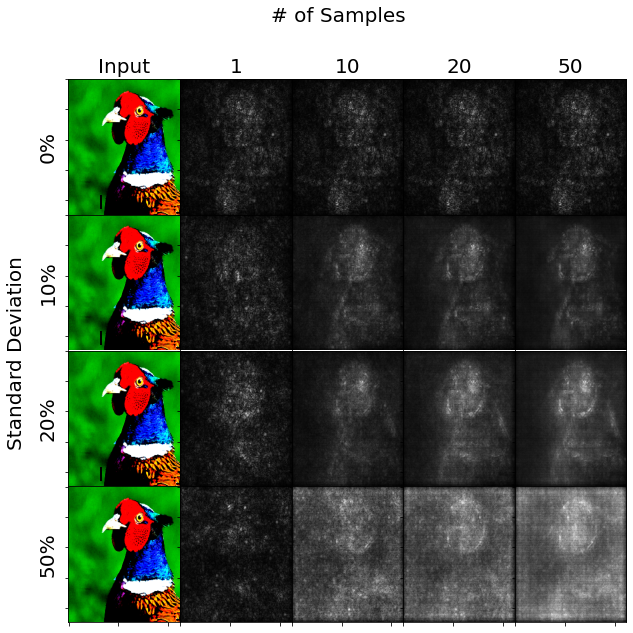

In [ ]:
stds = [0, 10,20,50] #adjsut fonts!!!!
sams = [1, 10,20,50]
fig, ax = plt.subplots(len(stds),len(sams)+1) 
for i in range(len(stds)):
  ax[i,0].imshow(image.permute(1,2,0))
  ax[i,0].set_xticklabels([])
  ax[i,0].set_yticklabels([])
  ax[i,0].set_aspect("auto")
  ax[i,0].set_ylabel("{}%".format(stds[i]),fontsize = 20)
  ax[i,0].set_title("Input", fontsize = 20)
  for j in range(len(sams)):
    ax[i, j+1].imshow(smoothGrad(stds[i], sams[j], image_final, alexnet)[0][0], cmap=plt.cm.gray)
    ax[i, j+1].set_xticklabels([])
    ax[i, j+1].set_yticklabels([])
    ax[i, j+1].set_aspect("auto")
    if i == 0:
      ax[i, j+1].set_title(str(sams[j]),fontsize = 20)
fig.subplots_adjust(wspace=0, hspace = 0)
fig.suptitle("# of Samples", fontsize = 20)
fig.text(0.04, 0.5, 'Standard Deviation', va='center', rotation='vertical',fontsize = 20)
fig.set_size_inches(10,10)
fig.savefig("/content/drive/MyDrive/Colab Notebooks/Project/output_images/smoothgrad_grid.jpg")

#fine